# Image Classification of Dogs and Cats via Pre-trained Network

The dataset can be leaded from https://www.kaggle.com/c/dogs-vs-cats. It contains 25k images of dogs and cats. First of all, we got to get features of those images using a pre-trained network. Then, we solve classification problem on the features be means of Linear Regression.

Let's visualize a couple of images.

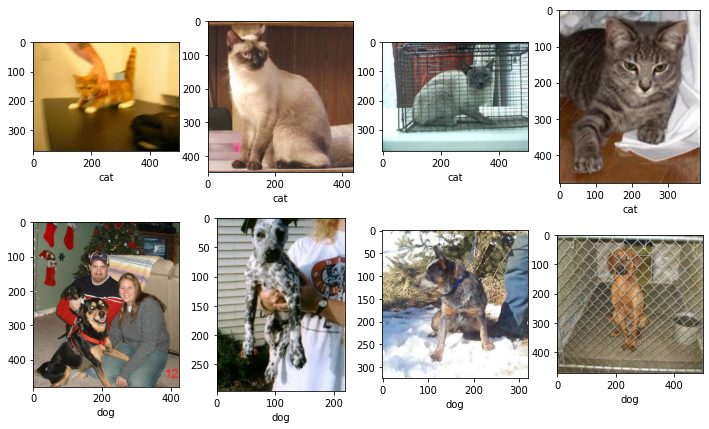

In [189]:
import os
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

file_names = os.listdir('_data/images')
examples = [[i, file_names[3500 * i]] for i in range(8)]

plt.figure(figsize=[12,7])
for i, file_name in examples:
    path = os.path.join('_data/images', file_name)
    plt.subplot(2, 4, i + 1)
    plt.xlabel('cat' if file_name.startswith("cat") else 'dog')
    plt.imshow(imread(path))

Load pre-trained model 

In [190]:
from torchvision.models.inception import inception_v3


model = inception_v3(pretrained=True, transform_input=True)
model.aux_logits = False
model.train(False);

Define the function which gets the image path and returns the features according to the model

In [191]:
import torch
import numpy as np
import PIL.Image as Image


def get_features_from_image_by(path, model):
    img = imread(path) #get image
    img = Image.fromarray(img).resize((299, 299)) # scale
    img = np.array(img).transpose([2, 0, 1]) / 255 #normalize
    img = torch.FloatTensor(img).unsqueeze(0) #reshape
    features = model(img).squeeze(0).data.numpy() # get features
    return features
    
path = os.path.join('_data/images', file_names[0])
features = get_features_from_image_by(path, model)
print(features.shape)

(1000,)


Get features and targets from the dataset

In [128]:
from tqdm import tqdm


X_data, y_data = [], []
for file_name in tqdm(file_names):
    
    path = os.path.join('_data/images', file_name)
    features = get_features_from_image_by(path, model)
    X_data.append(features)
    
    target = file_name.startswith("cat")
    y_data.append(target)

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [44:49<00:00,  9.30it/s]


Save the features and targets

In [192]:
np.save('_data/dataset/X_data', np.array(X_data))
np.save('_data/dataset/y_data', np.array(y_data))

Split the dataset

In [193]:
from sklearn.model_selection import train_test_split
import numpy as np


X_data = np.load('_data/dataset/X_data.npy')
y_data = np.load('_data/dataset/Y_data.npy')
print(f'X_data shape: {X_data.shape}, y_data shape: {y_data.shape}')

X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data, test_size=.3, random_state=3)
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_valid shape: {X_valid.shape}, y_valid shape: {y_valid.shape}')

X_data shape: (25000, 1000), y_data shape: (25000,)
X_train shape: (17500, 1000), y_train shape: (17500,)
X_valid shape: (7500, 1000), y_valid shape: (7500,)


Normalize the dataset

In [170]:
from sklearn.preprocessing import normalize
norm_X_train = normalize(X_train)
norm_X_valid = normalize(X_valid)

Try to use Logistic Regression, Ridge Classifier, and Random Forest Classifier

In [179]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression(C=1, random_state=3, n_jobs=-1)
logistic_regression.fit(norm_X_train, y_train)
print('Logistic Regression score on the train set = ', \
      round(logistic_regression.score(norm_X_train, y_train), 3))
y_pred = logistic_regression.predict(norm_X_valid)
print('Logistic Regression score on the validation set = ', \
      round(np.mean(y_valid == y_pred), 3))

Logistic Regression score on the train set =  0.989
Logistic Regression score on the validation set =  0.988


In [185]:
from sklearn.linear_model import RidgeClassifier


ridge_classifier = RidgeClassifier(alpha=0.01, random_state=3)
ridge_classifier.fit(norm_X_train, y_train)
print('Ridge Classifier score on the train set = ', \
      round(ridge_classifier.score(norm_X_train, y_train), 3))
y_pred = ridge_classifier.predict(norm_X_valid)
print('Ridge Classifier score on the validation set = ',\
      round(np.mean(y_valid == y_pred), 3))

Ridge Classifier score on the train set =  0.992
Ridge Classifier score on the validation set =  0.99


In [186]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(random_state=3, max_depth=10, n_jobs=-1)
random_forest.fit(X_train, y_train)
random_forest.score(X_train, y_train)
print('Random Forest score on the train set = ', \
      round(ridge_classifier.score(X_train, y_train), 3))
y_pred = random_forest.predict(X_valid)
print('Random Forest score on the validation set = ',\
      round(np.mean(y_valid == y_pred), 3))

Random Forest score on the train set =  0.983
Random Forest score on the validation set =  0.985


### Conclusion

According to the experiments, the best classifier is Ridge Classifier with **0.99%** accuracy.